# Plotting NOAA's nClimGrid Daily Stored in AWS
## Written By Jared Rennie

This tutorial uses python to download and plot data from NOAA's nClimGrid Daily Database

### What You Need

First off, the entire codebase works in Python... sort of. 

You will need the following programs installed: 
- Python
- s3fs | numpy | xarray | matplotlib | cartopy | h5netcdf | h5py 
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com/' target="_blank">Anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import Packages
import sys, time, datetime, math, calendar
import s3fs

import numpy as np
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

print("SUCCESS")

SUCCESS


### Choose a date and element

If you made it this far, great!

<a href='https://www.ncei.noaa.gov/products/land-based-station/nclimgrid-daily' target='blank'>NOAA's nClimGrid Daily </a> is a gridded, 5km dataset of daily temperature (max,min,avg) and precipitation for the Contiguous United States going back to 1951. There are gridded netCDF versions, and also values aggregated to certain regions (county, state, NWS Forecast Office). If you ever wanted to investigate the data, you can check them out at these locations:

- **WWW:** <a href='https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/' target = 'blank'>https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/</a>
- **AWS:** s3://noaa-nclimgrid-daily-pds/v1-0-0/

This block of code will utilize the AWS bucket and take one day, and one element, and plot it in Python. We have to submit arguments to indicate the day and element we want. **Let's pick a random day of no importance (or pick one yourself)**

In [2]:
#Insert Arguments Here
year= 2004 
month= 10
day= 27
element= 'tmax' 

This next block will set up some date and plotting info, based on the arguments chosen above.

Feel free to play with the date formatting, color schemes, and bounds I've used. 

<a href='https://colorbrewer2.org/' target='blank'>ColorBrewer</a> is an excellent website to help one figure out color schemes.

In [3]:
# Get some Info Based on Date
day_counter=int(day)
current_date="%04i-%02i-%02i" % (int(year),int(month),int(day))
current_month="%04i%02i" % (int(year),int(month))

# Set info based on Element
if element == "tmax" or element == "tmin" or element == "tavg":
    unit='°F'
    if element=='tmax':
        element_name='Maximum Temperature'
    if element=='tmin':
        element_name='Minimum Temperature'    
    if element=='tavg':
        element_name='Average Temperature'

    # Set Up Color Map
    cmap='RdYlBu_r' 
    bounds=np.array([0,10,20,30,40,50,60,70,80,90,100,110])   
        
if element == "prcp":
    unit='inches'  
    element_name='Precipitation'

    # Set Up Color Map
    cmap='YlGnBu' 
    bounds=np.array([0.01,0.10,0.25,0.50,0.75,1.00,2.00,3.00,4.00], dtype='f')

# Set up some other Plotting info
dpi=100
ocean_hex='#ececeb'
land_hex='#d2d6d6'

### Ok let's read some data.

nClimGrid Daily is updated each day, so you should be able to get the most recent data. This block of code will attempt to find the necessary data in the AWS bucket. The netCDF files are stored by month. Since this data is publicly available via the <a href="https://www.noaa.gov/information-technology/big-data" target="blank">NOAA Open Data Dissemination (NODD) Project</a>, anonymous data read should be fine (`anon=True`)

Also, since the data is updated frequently, some of the most recent files indicate 'prelim' for preliminary, and finalized versions are noted as 'scaled.' This block of code will read in the data from AWS, knowing this discrepancy.

In [4]:
#################################################
# READ IN DATA FROM AWS

# Open File System
s3 = s3fs.S3FileSystem(anon=True)

# Get Specific File Based on Inputs
aws_year="%04i" % (int(year))
aws_month="%02i" % (int(month))
aws_version='prelim'
aws_url='s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/'+aws_year+'/ncdd-'+aws_year+aws_month+'-grd-'+aws_version+'.nc'

# Read in Data
print('READING IN nClimGrid DATA FROM AWS: ',aws_url)
try:
    aws_file=s3.open(aws_url)
except:
    aws_version='scaled'
    aws_url='s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/'+aws_year+'/ncdd-'+aws_year+aws_month+'-grd-'+aws_version+'.nc'
    print('FAILED, TRYING THIS URL: ',aws_url)
    aws_file=s3.open(aws_url)

data_monthly = xr.open_dataset(aws_file)
print("SUCCESS!")

READING IN nClimGrid DATA FROM AWS:  s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/2004/ncdd-200410-grd-prelim.nc
FAILED, TRYING THIS URL:  s3://noaa-nclimgrid-daily-pds/v1-0-0/grids/2004/ncdd-200410-grd-scaled.nc
SUCCESS!


### Examining the data
You may get a warning after reading the data, but if you've made it this far, congrats, you read in data from AWS! 

Well, let's made sure it was read in correctly:

In [5]:
data_monthly

<xarray.Dataset>
Dimensions:  (time: 31, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 2004-10-01 2004-10-02 ... 2004-10-31
  * lat      (lat) float32 24.56 24.6 24.65 24.69 ... 49.23 49.27 49.31 49.35
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tmax     (time, lat, lon) float64 ...
    tmin     (time, lat, lon) float64 ...
    prcp     (time, lat, lon) float64 ...
    tavg     (time, lat, lon) float64 ...
Attributes: (12/33)
    date_created:               2022-09-02 02:28:47.073954
    date_modified:              2022-09-02 02:28:47.074870
    Conventions:                CF-1.7, ACDD-1.3
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      nClimGrid-Daily, Gridded Fields
    source:                     GHCN-Daily, nClimGrid-Monthly
    ...                         ...
    time_coverage_start:        2004-10-01
    time_coverage_end:          2004-10-31
    program:                    Center for Weather and Climate/Climate Scienc...
    geospatial_lat_resolution:  0.04167 degrees
    geospatial_lon_resolution:  0.04167 degrees
    platform:                   station

The netCDF file should have lat (596 points) and lon (1385 points) dimensions, with a time dimension indicating how many days in the month. 

You'll also notice that the lat/lon values are noted in degrees. This will be important later. 

Let's go ahead and get the lat/lon values, as well as the data for a particular day. This data is originally in metric (C and mm) units, so we will convert to imperial units (F and inches) here.

In [6]:
# Get Lat/Lons
nclimgrid_lats=data_monthly.lat.values
nclimgrid_lons=data_monthly.lon.values

# Get Data, Convert from metric
if element == 'prcp':
    conus_value=(data_monthly[element].values[day_counter-1,:,:] * 0.0393701)  
else:
    conus_value=(data_monthly[element].values[day_counter-1,:,:] * 1.8) + 32.

In [7]:
conus_value

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Gah! Nan's? Well Don't worry, there's data (I promise). To prove it, let's pick one gridpoint

In [8]:
print(conus_value[300,300])

56.553125


See? Nothing to Worry About. 

Now for the fun part...

### Plotting the data!

But before we get there, we want YOU to be the creator of the final product (not me!) So let's give credit to yourself:

In [9]:
author='Not Jared Rennie'

Ok, now let's plot. The following block of code does the following:

- Set up the colorbar
- Create the Figure in the Lambert Conformal Projection
- Adjust the map to fit CONUS
- Add boundaries such as US States
- Plot the data we have aquired
- Add colorbar and other info (including authorship!) 
- Show the results

I would take a good look at this block. This is the result of months of trial and error to make this great! Feel free to tinker (if you're feeling confident)

**PRO TIP**: This took me forever to realize, but since cartopy projections and transformations can be frustrating, I'm going to give you a piece of advice
1. The projection you want the final output to be in is indicated here: 

`ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())`

2. In order for the data to match to the projection indicated in 1. above, you must indicate what the projection of the data currently is when plotting: 

`ax.pcolormesh(nclimgrid_lons, nclimgrid_lats, conus_value,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)`

In other words, we know the data is in a lat/lon projection, so using these two commands indicate that the data is in lat/lon `ccrs.PlateCarree()` and we want to re-project onto the map `ccrs.LanbertConformal()` 

PLOTTING CONUS


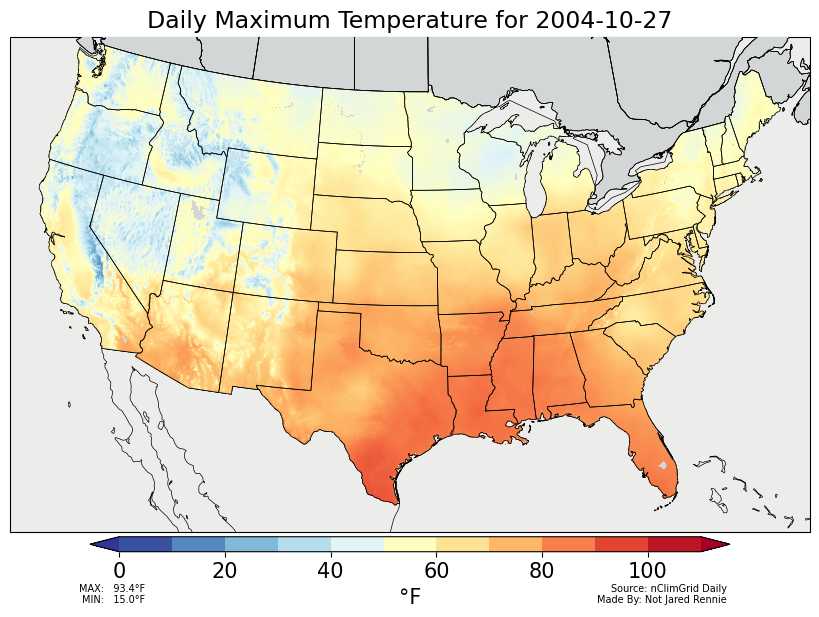

In [10]:
#################################################
# PLOTTING CONUS
print("PLOTTING CONUS")

# Set Up Colorbar info
vmin=np.min(bounds)
vmax=np.max(bounds)
extend='both'
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
cm = plt.cm.ScalarMappable(cmap=cmap)
cm.set_array(np.array(conus_value))
cm.set_clim(vmin, vmax)

# Set CONUS Bounds
minLat = 22    
maxLat = 50   
minLon = -120 
maxLon = -73 

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.Geodetic())
ax.set_facecolor(ocean_hex)

# Add Boundaries
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.BORDERS,linewidth=0.5)
ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,zorder=9)
ax.add_feature(cfeature.STATES,linewidth=0.5,zorder=10)

# Plot Data
ax.pcolormesh(nclimgrid_lons, nclimgrid_lats, conus_value,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,zorder=9)

# Add Colorbar
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar=plt.colorbar(cm, cax=cax,boundaries=bounds,orientation='horizontal',extend=extend,spacing='uniform')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(unit,size=15)

# Annotate Info On Graphic
nclimgrid_max="%6.1f" % np.nanmax(conus_value)
nclimgrid_min="%6.1f" % np.nanmin(conus_value)
plt.annotate('Source: nClimGrid Daily\nMade By: '+author,xy=(1.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
if element == "prcp":
    plt.annotate('MAX: '+str(nclimgrid_max)+'"\nMIN: '+str(nclimgrid_min)+'"',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')
else:
    plt.annotate('MAX: '+str(nclimgrid_max)+'°F\nMIN: '+str(nclimgrid_min)+'°F',xy=(0.045, -3.51), xycoords='axes fraction', fontsize=7,color='black',horizontalalignment='right', verticalalignment='bottom')

# Add Title and Save to File
plt.suptitle('Daily '+element_name+' for '+current_date,size=17,color='black',y=1.05) 
plt.show() 
plt.clf()
plt.close()

Isn't it beautiful?

**Congrats on completing this notebook! Now go forth and make better plots!**

### Some other challenges you could try
- Maybe you only want to plot a certain area (such as North and South Carolina)?
- One in theory could calculate diurnal temperature range, which is max minus min
- How could one add county lines, or point data indicating cities. Could other shapefiles be added as layers?
- There's other gridded data publicly available from the NOAA Big Data Project. Could one plot that as well?